# Context
This notebook drives the training process for different models.

In [1]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [2]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup

In [3]:
def get_latest_file(folder_path):
  files = [f for f in os.listdir(folder_path) if "_" in f]
  latest = max(files)
  return os.path.join(folder_path, latest)

TRAIN_classes = "all-classes"
num_classes = 37
biggest_num_classes_tested = 37
scores_path = get_latest_file(
  os.path.join(sup.SCORES_ROOT, 
               "specified", 
               sup.TRAIN_KNN_CODE, 
               TRAIN_classes))

print(scores_path)

top_barrier=10

/Users/diego/Desktop/iteso/TOG/scores/specified/KNN/all-classes/PREPanalysis-2025-06-19_21:25:26.csv


## Helper functions

In [4]:
import math

def significance(row):
  C = int(row["num_classes"])
  score = row['accuracy']
  unit = 1 if row["data_unit"] == sup.DATA_S_PV else 12
  N = 100 * unit * C

  chance_score = 1 / C
  sigma_acc = math.sqrt(chance_score * (1 - chance_score) / N)

  z = (score - chance_score)/sigma_acc

  return z

def harmonic_z(row, recall_col='macro_recall_z', precision_col='macro_precision_z'):
    recall_z = row[recall_col]
    precision_z = row[precision_col]

    # Handle zero or undefined cases
    if recall_z + precision_z == 0:
        return 0  # or np.nan if you want to mark it

    return 2 * recall_z * precision_z / (recall_z + precision_z)
                

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
def visualize(df: pd.DataFrame, group_cols, top, filter_cols=None, filter_values=None, sortby='accuracy_z'):
  """
  Optionally filters df by filter_cols == filter_values, groups by group_cols,
  selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
  """
  filter_desc = ""

  # Optional filtering
  if filter_cols and filter_values:
    for col, val in zip(filter_cols, filter_values):
      df = df[df[col] == val]
    filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

  if df.empty:
    print("Warning: DataFrame is empty after filtering.")
    return

  # Group + mean of top k
  def top_k_mean(g):
    top_k = g.sort_values(f'{sortby}', ascending=False).head(top)
    if top_k.empty:
      return float('nan')  # or 0.0
    return top_k[f'{sortby}'].mean()

  mean_accuracies = (
      df.groupby(group_cols)
        .apply(top_k_mean)
        .to_frame(f'mean_{sortby}')
        .reset_index()
  )

  if mean_accuracies.empty:
    print("Warning: No data to plot after grouping.")
    return

  # Create labels
  mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

  # Plotting
  colors = sns.color_palette("muted", len(mean_accuracies))
  plt.figure(figsize=(20, 12))
  plt.bar(mean_accuracies['label'], mean_accuracies[f'mean_{sortby}'], color=colors)

  plt.ylabel(f"Mean {sortby} (Top {top})")
  plt.title(f"Top {top} Mean {sortby} per {' + '.join(group_cols)}{filter_desc}")
  plt.xticks(rotation=45, ha='right')

  # Add y-limit padding
  min_val = mean_accuracies[f'mean_{sortby}'].min()
  max_val = mean_accuracies[f'mean_{sortby}'].max()
  padding = (max_val - min_val) * 0.3 if max_val > min_val else 0.1
  plt.ylim(max(min_val - padding, 0), max_val + padding)

  # Add value labels
  for i, val in enumerate(mean_accuracies[f'mean_{sortby}']):
    plt.text(i, val + padding * 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()



In [7]:
def evolution(df, metric='accuracy_z', prep_cols=None, top=top_barrier):
    if prep_cols is None:
        prep_cols = []
    df = df.copy()

    # build the prep_label
    df['prep_label'] = df.apply(lambda r: " | ".join(f"{c}={r[c]}" for c in prep_cols), axis=1)

    # for each strategy & each num_classes, take top_n rows by metric
    def topn_mean(group):
        topn = group.nlargest(top, metric)
        return pd.Series({
            metric: topn[metric].mean(),
            # if you want, you could also compute other stats here
        })

    summary = (df
               .groupby(['prep_label', 'num_classes'])
               .apply(topn_mean)
               .reset_index())

    # now plot the summarized means
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=summary,
        x='num_classes',
        y=metric,
        hue='prep_label',
        marker='o'
    )
    plt.title(f'{metric} (mean of top {top}) vs. Number of Classes')
    plt.xlabel('Number of Classes')
    plt.ylabel(metric)
    plt.grid(True)
    #plt.yscale('log')
    plt.legend(title='Prep Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


## Data

In [8]:
all_scores_df = pd.read_csv(scores_path)

In [9]:
# Model to use for Active Hand detection
all_scores_df[all_scores_df['data_unit'] == sup.DATA_AH_PF].sort_values(by='accuracy', ascending=False)

,data_unit,class_list,difficulty,num_classes,class_name_list,PH2,PH3,reducer,kernel,num_components,k,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall
314,AHpf,active_hand,unspecified,2,"['inactive', 'active']",True,True,pca,NaN,14,5,0.986028,1.0,0.986028,0.986051,0.986036
362,AHpf,active_hand,unspecified,2,"['inactive', 'active']",True,False,NaN,NaN,75,5,0.986028,1.0,0.986028,0.986051,0.986036
270,AHpf,active_hand,unspecified,2,"['inactive', 'active']",True,True,kpca,poly,12,5,0.986028,1.0,0.986028,0.986051,0.986036
338,AHpf,active_hand,unspecified,2,"['inactive', 'active']",True,True,pca,NaN,15,5,0.986028,1.0,0.986028,0.986051,0.986036
186,AHpf,active_hand,unspecified,2,"['inactive', 'active']",True,True,kpca,cosine,8,5,0.986028,1.0,0.986028,0.986051,0.986036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,AHpf,active_hand,unspecified,2,"['inactive', 'active']",True,True,kpca,sigmoid,1,1,0.557884,1.0,0.557880,0.557896,0.557892
377,AHpf,active_hand,unspecified,2,"['inactive', 'active']",False,True,kpca,sigmoid,1,3,0.542914,1.0,0.542652,0.542959,0.542869
379,AHpf,active_hand,unspecified,2,"['inactive', 'active']",False,True,kpca,sigmoid,1,7,0.535928,1.0,0.535361,0.536026,0.535861
376,AHpf,active_hand,unspecified,2,"['inactive', 'active']",False,True,kpca,sigmoid,1,1,0.529940,1.0,0.529835,0.529936,0.529912


In [10]:
scores_df = all_scores_df[all_scores_df['data_unit'] != sup.DATA_AH_PF]
scores_df.sort_values(by="accuracy", ascending=False)

,data_unit,class_list,difficulty,num_classes,class_name_list,PH2,PH3,reducer,kernel,num_components,k,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall
1452,Spf,specified,easy,3,"['w', '6', '10']",False,False,NaN,NaN,72,1,0.998691,0.649215,0.998652,0.998582,0.998728
2908,Spf,specified,hard,3,"['g', '4', '8']",False,False,NaN,NaN,72,1,0.997389,0.644909,0.997345,0.997163,0.997549
2180,Spf,specified,average,3,"['d', 'j', 'u']",False,False,NaN,NaN,72,1,0.994812,0.683528,0.994817,0.994906,0.994744
2876,Spf,specified,hard,3,"['g', '4', '8']",False,True,kpca,cosine,14,1,0.994778,0.644909,0.994694,0.994374,0.995098
2861,Spf,specified,hard,3,"['g', '4', '8']",False,True,pca,NaN,14,3,0.994778,0.644909,0.994694,0.994374,0.995098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36779,Spf,specified,average,35,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,kpca,sigmoid,1,7,0.030399,0.055713,0.026920,0.031697,0.029833
78606,Spv,specified,average,37,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,kpca,rbf,15,5,0.029449,0.067862,0.023485,0.031144,0.029931
77878,Spv,specified,easy,37,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,kpca,rbf,15,5,0.029449,0.067862,0.023485,0.031144,0.029931
79334,Spv,specified,hard,37,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,kpca,rbf,15,5,0.029449,0.067862,0.023485,0.031144,0.029931


In [11]:
print(scores_df.columns.to_list())

['data_unit', 'class_list', 'difficulty', 'num_classes', 'class_name_list', 'PH2', 'PH3', 'reducer', 'kernel', 'num_components', 'k', 'accuracy', 'top2accuracy', 'macro_f1', 'macro_precision', 'macro_recall']


In [12]:
scores_df['accuracy_z'] = scores_df.apply(significance, axis=1)

scores_df

/var/folders/y5/xympzvrs537ffwjygt2x7wnh0000gn/T/ipykernel_8316/931245551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df['accuracy_z'] = scores_df.apply(significance, axis=1)


,data_unit,class_list,difficulty,num_classes,class_name_list,PH2,PH3,reducer,kernel,num_components,k,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall,accuracy_z
728,Spf,specified,easy,3,"['w', '6', '10']",True,True,pca,NaN,1,1,0.507853,0.649215,0.508839,0.507803,0.510744,22.212778
729,Spf,specified,easy,3,"['w', '6', '10']",True,True,pca,NaN,1,3,0.524869,0.649215,0.526968,0.529357,0.527770,24.378524
730,Spf,specified,easy,3,"['w', '6', '10']",True,True,pca,NaN,1,5,0.570681,0.649215,0.569700,0.575993,0.576600,30.209379
731,Spf,specified,easy,3,"['w', '6', '10']",True,True,pca,NaN,1,7,0.568063,0.649215,0.566270,0.572566,0.573637,29.876187
732,Spf,specified,easy,3,"['w', '6', '10']",True,True,kpca,poly,1,1,0.573298,0.649215,0.573680,0.571554,0.578175,30.542570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79347,Spv,specified,hard,37,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,True,umap,NaN,15,7,0.254802,0.067862,0.251377,0.293657,0.264568,85.439059
79348,Spv,specified,hard,37,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1,0.599232,0.067862,0.597694,0.618465,0.599145,214.636104
79349,Spv,specified,hard,37,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,3,0.485275,0.067862,0.485221,0.524842,0.493667,171.890613
79350,Spv,specified,hard,37,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,5,0.441741,0.067862,0.442484,0.482990,0.455297,155.560875


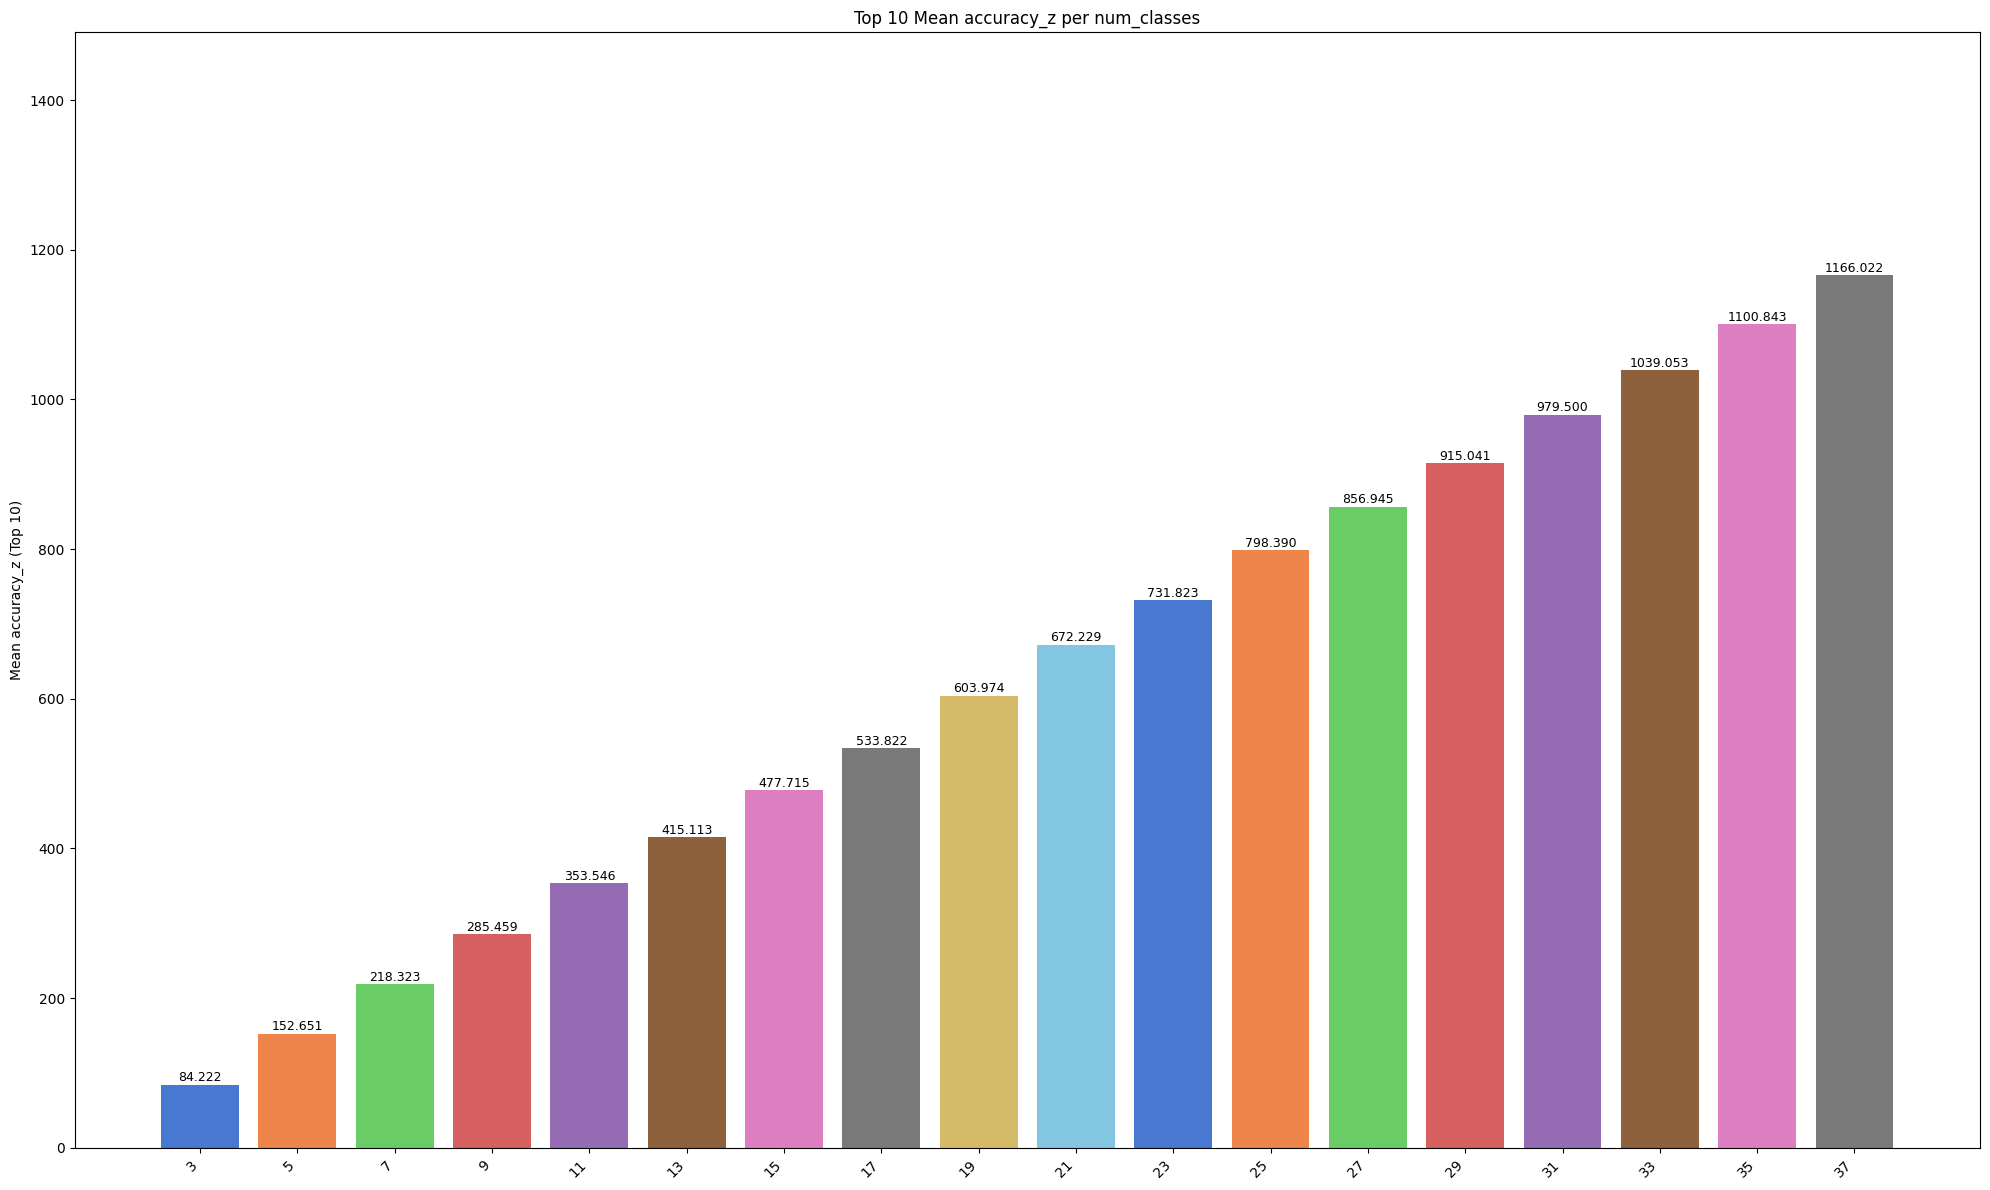

In [13]:
visualize(scores_df, group_cols=['num_classes'], top=top_barrier)

### Inital number-of-classes-agnostic analysis

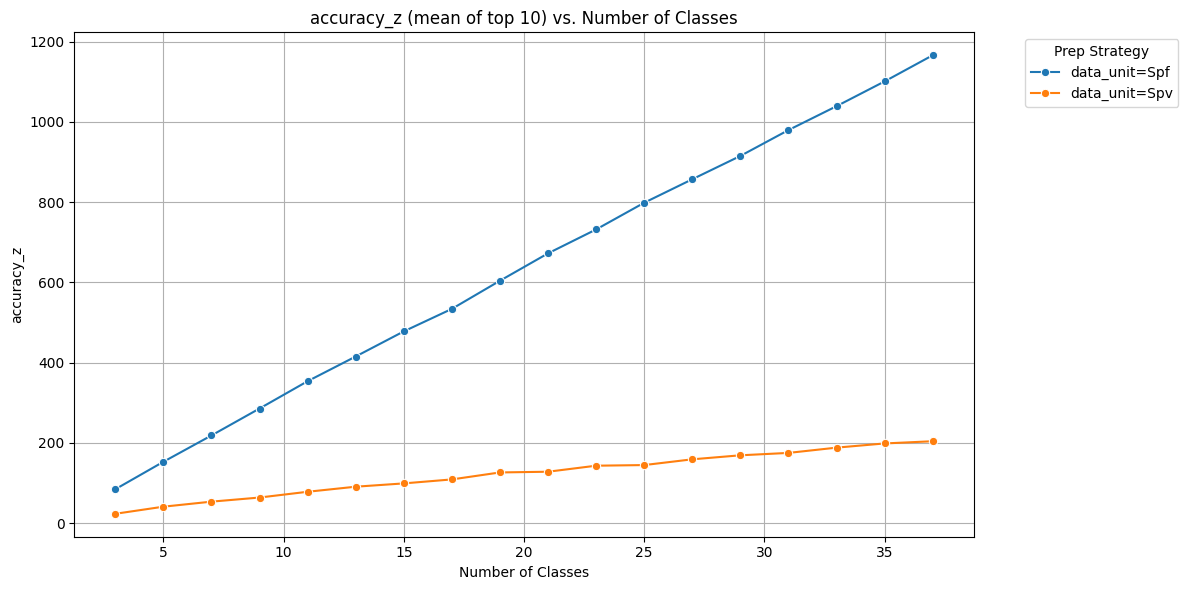

In [14]:
evolution(scores_df, prep_cols=['data_unit'])

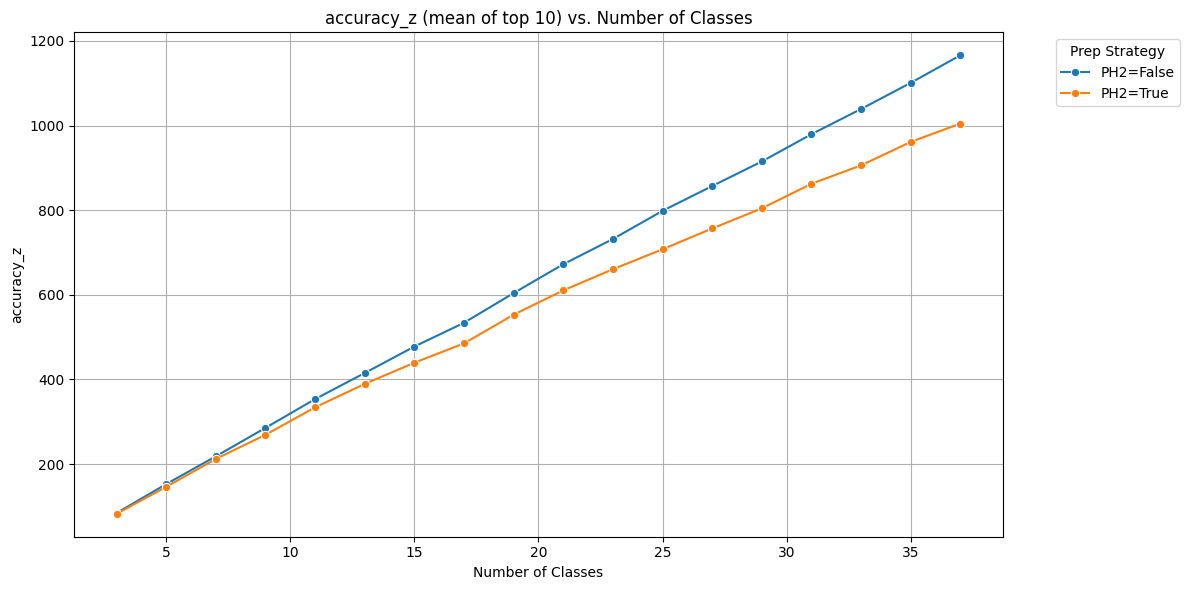

In [15]:
evolution(scores_df, prep_cols=['PH2'])

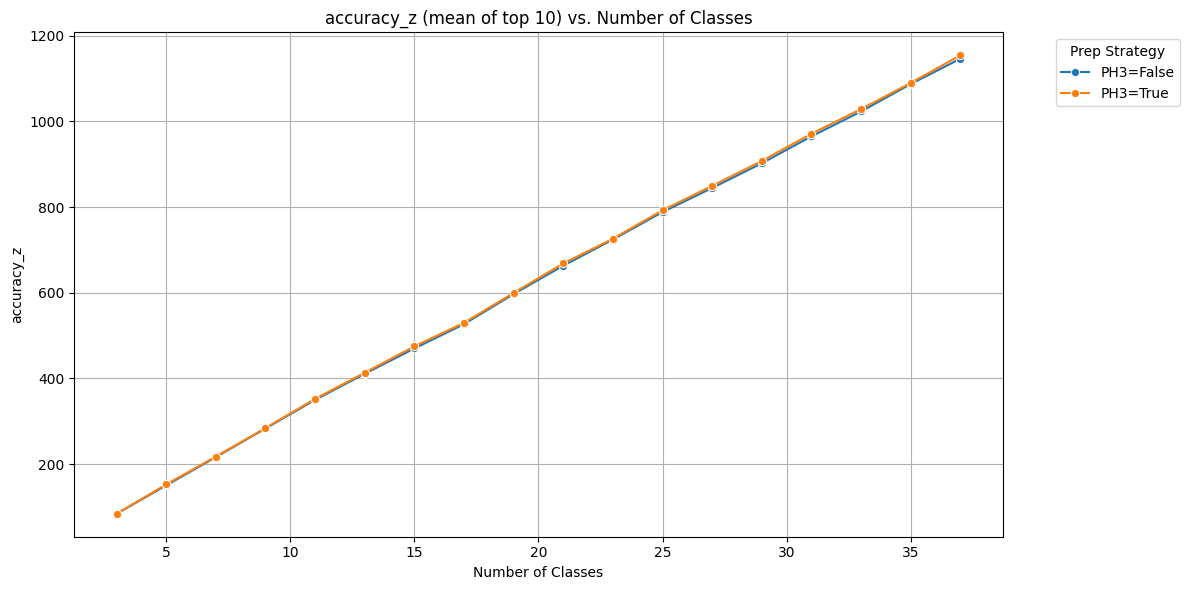

In [16]:
evolution(scores_df, prep_cols=['PH3'])

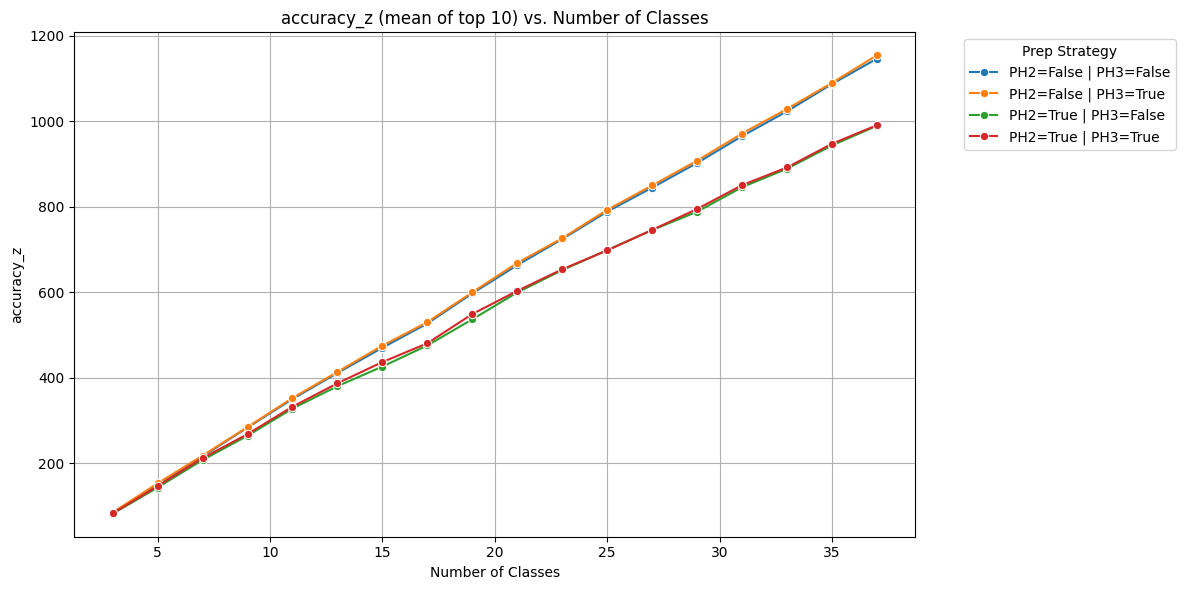

In [17]:
evolution(scores_df, prep_cols=['PH2','PH3'])

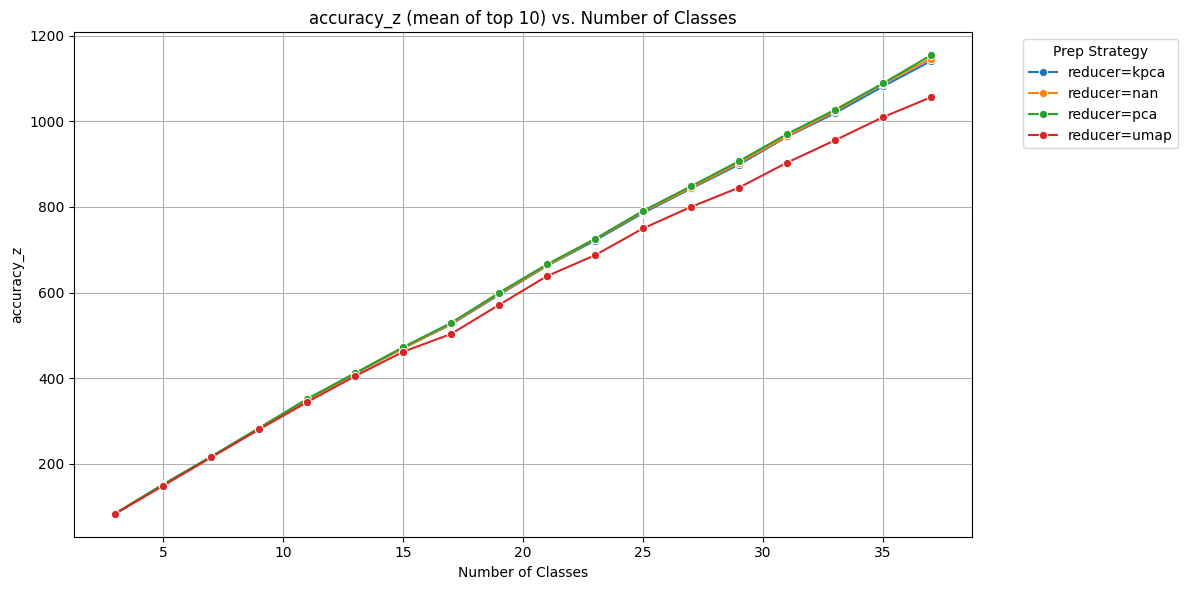

In [18]:
evolution(scores_df, prep_cols=['reducer'])

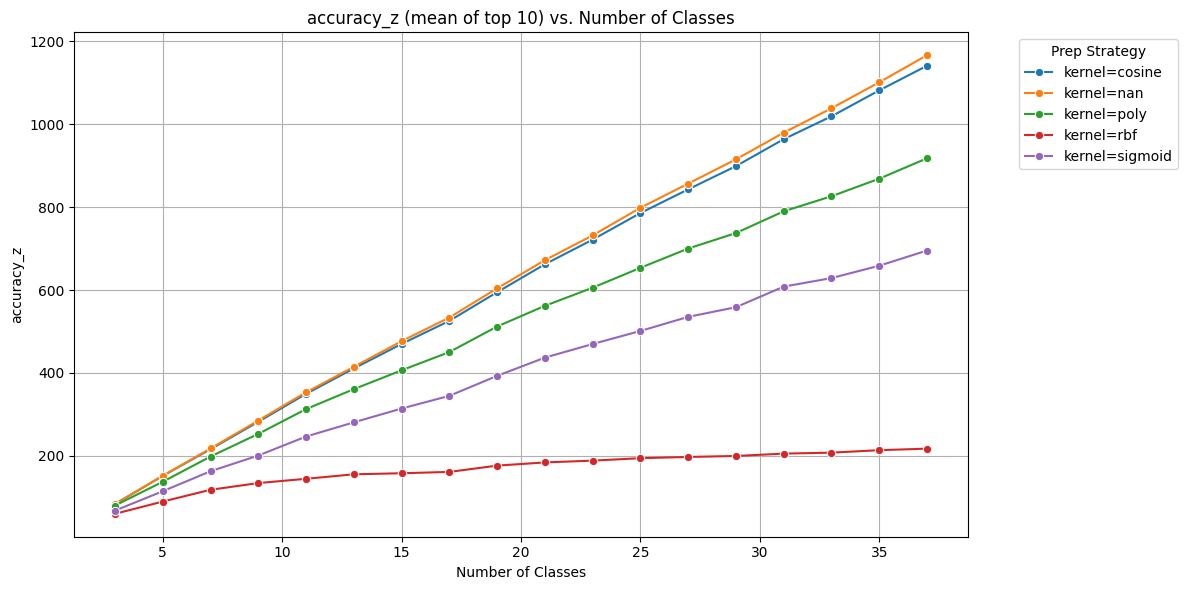

In [19]:
evolution(scores_df, prep_cols=['kernel'])

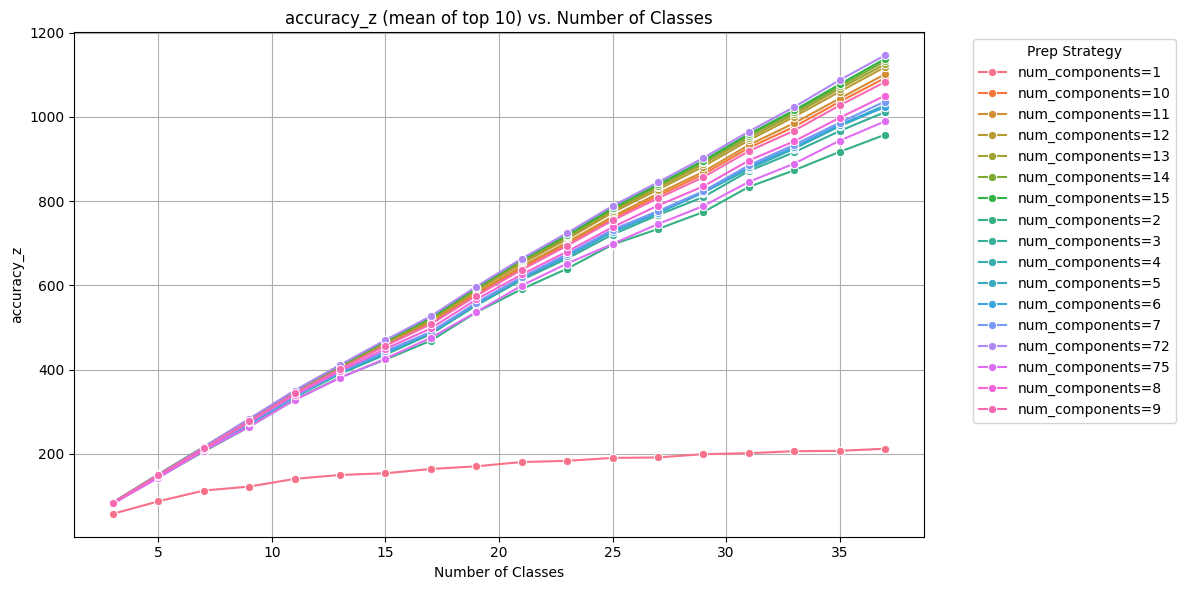

In [20]:
evolution(scores_df, prep_cols=['num_components'])

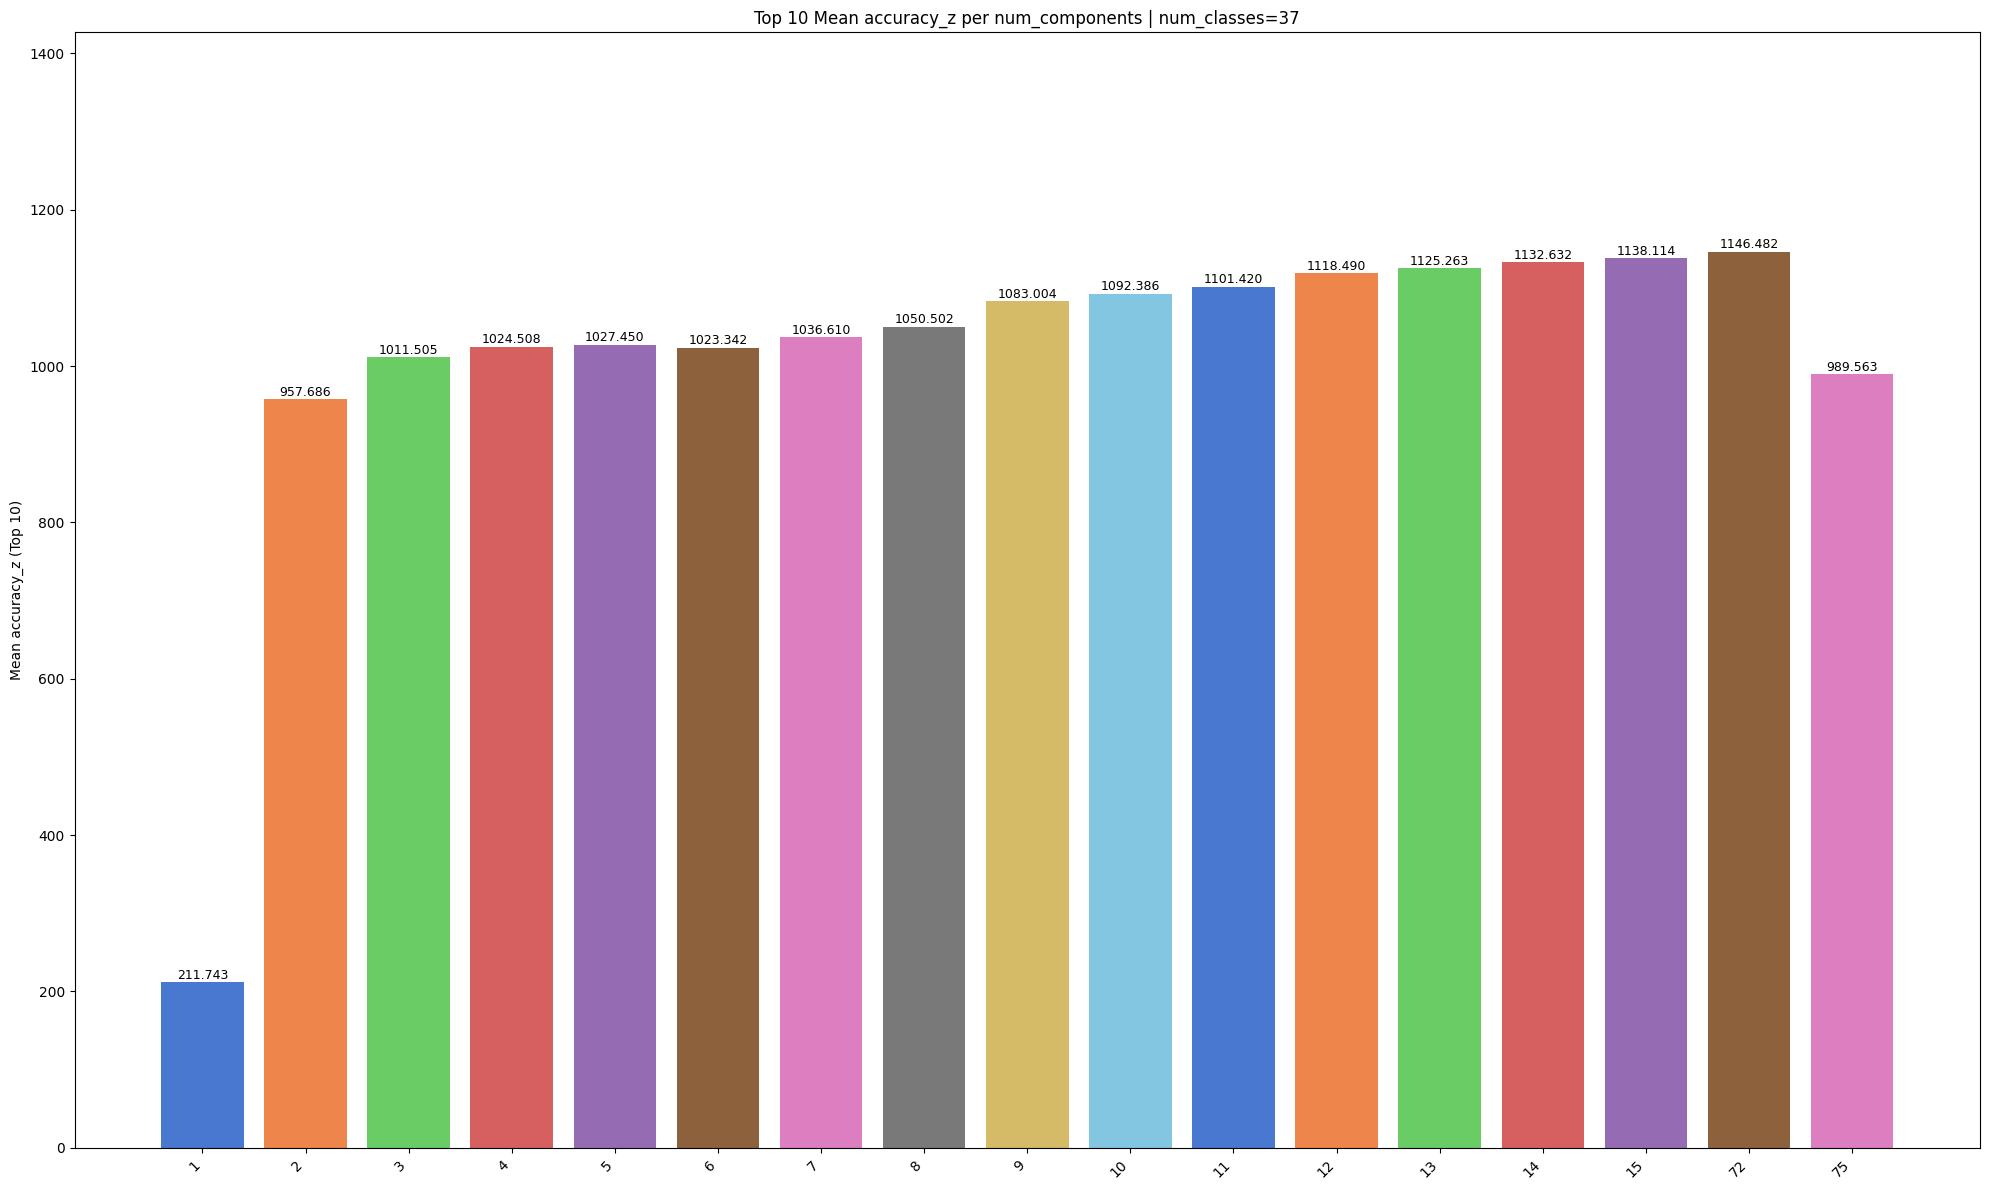

In [21]:
visualize(scores_df, group_cols=['num_components'], filter_cols=['num_classes'], filter_values=[biggest_num_classes_tested], top=top_barrier)

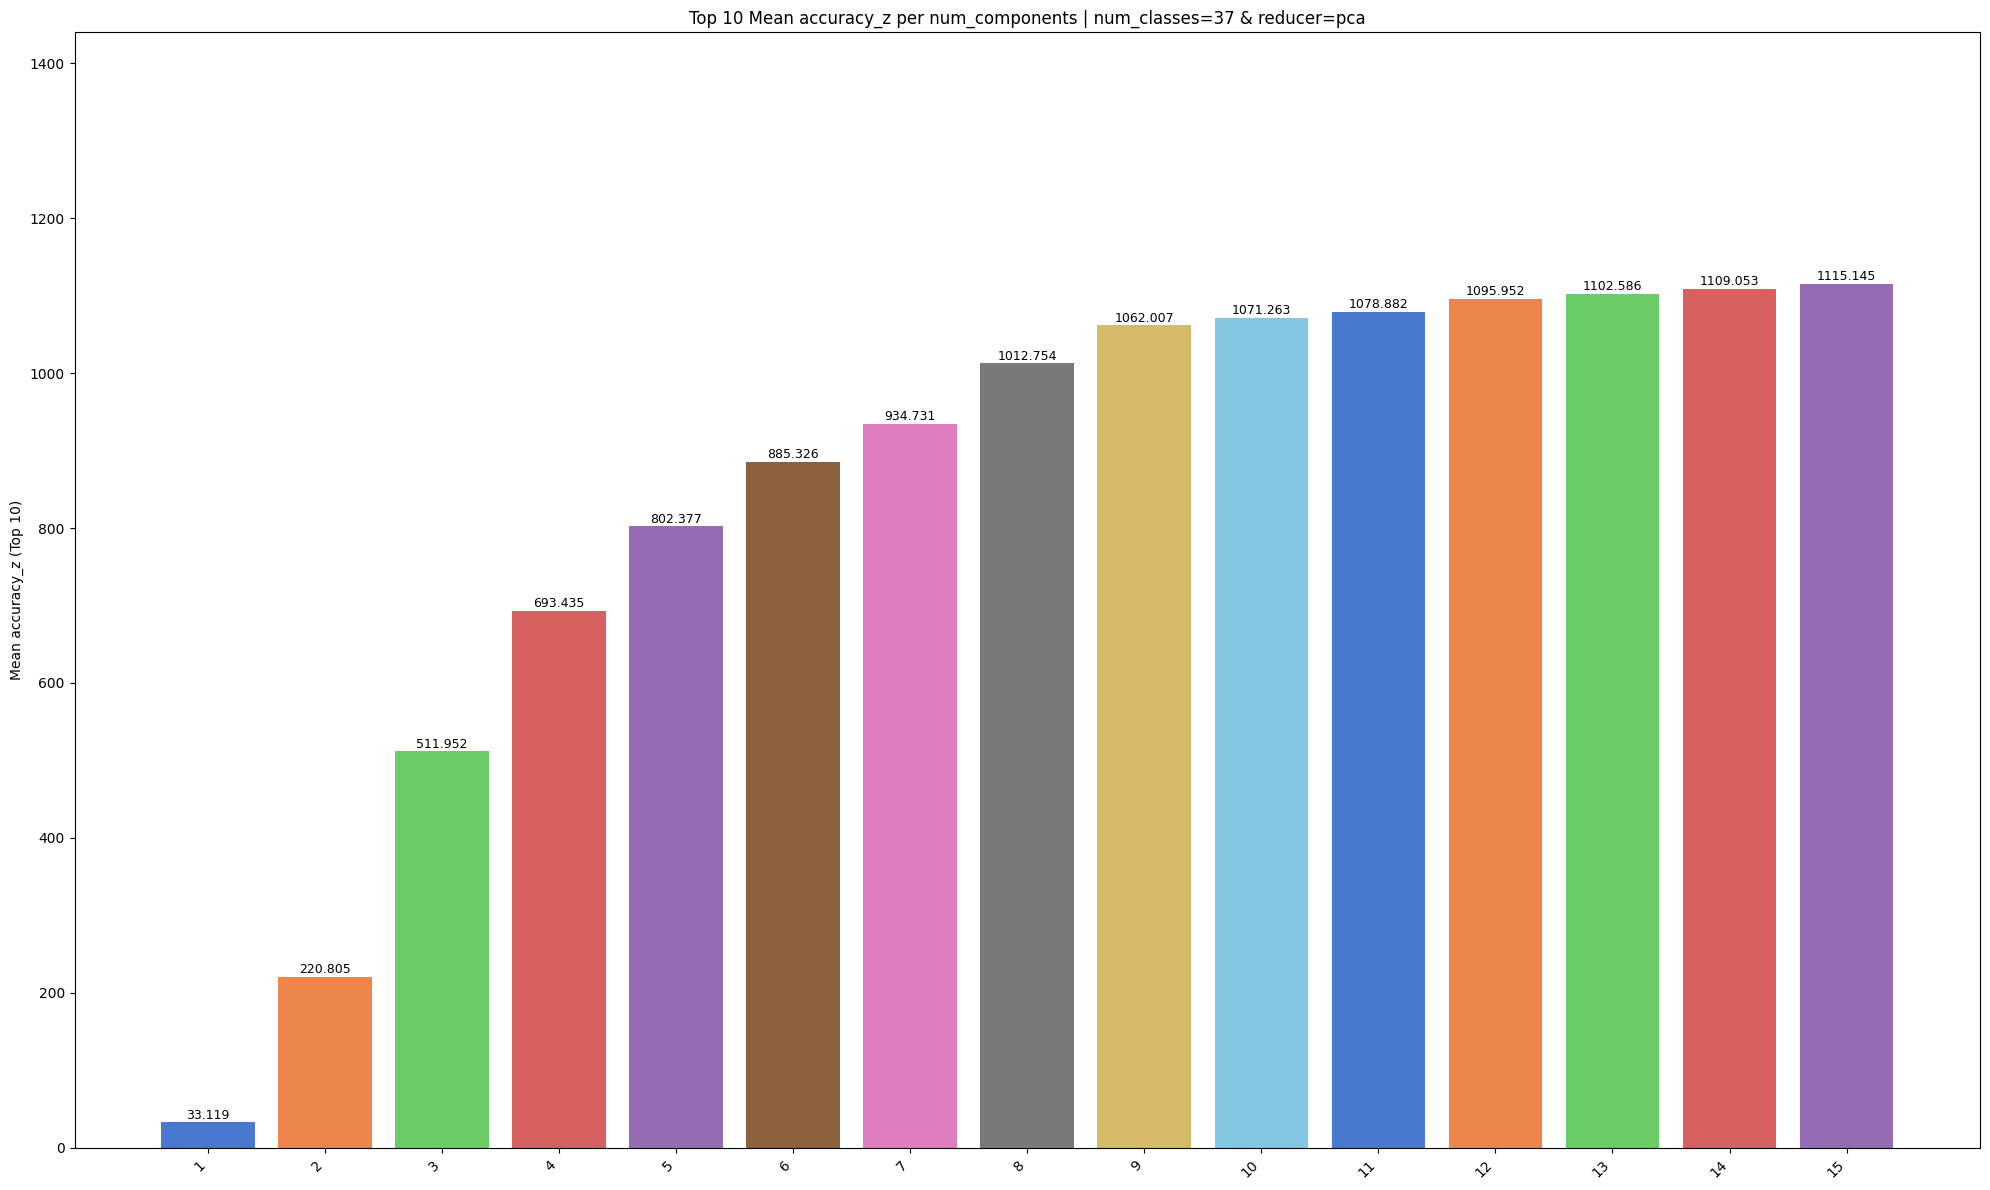

In [22]:
visualize(scores_df, group_cols=['num_components'], filter_cols=['num_classes', 'reducer'], filter_values=[biggest_num_classes_tested, sup.PH3_REDUCER_NAME_PCA], top=top_barrier)

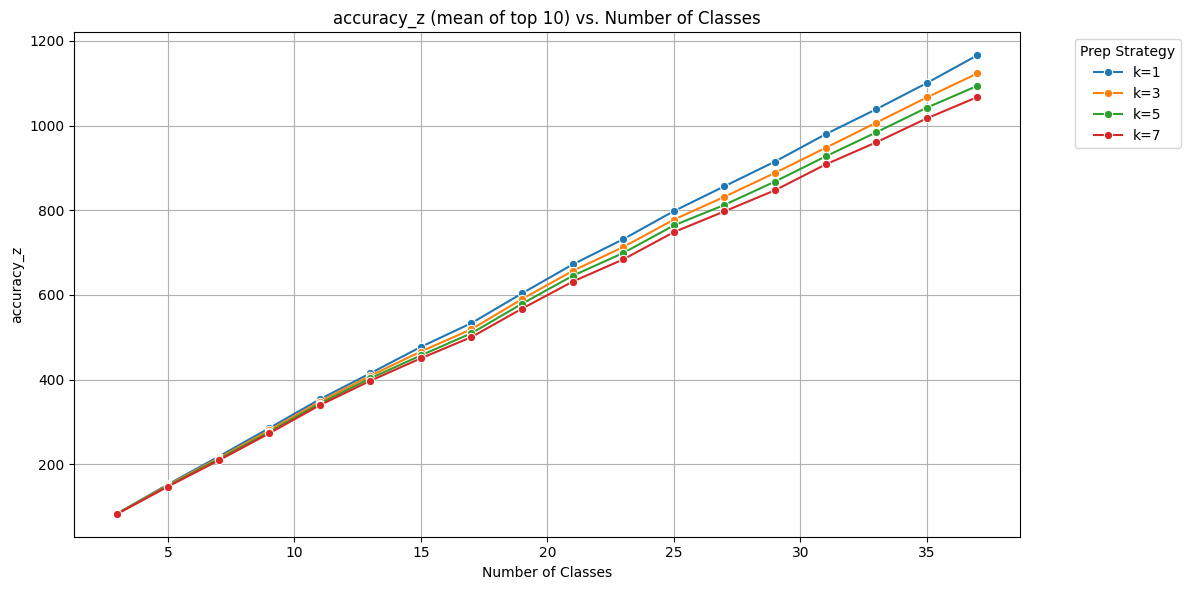

In [23]:
evolution(scores_df, prep_cols=['k'])

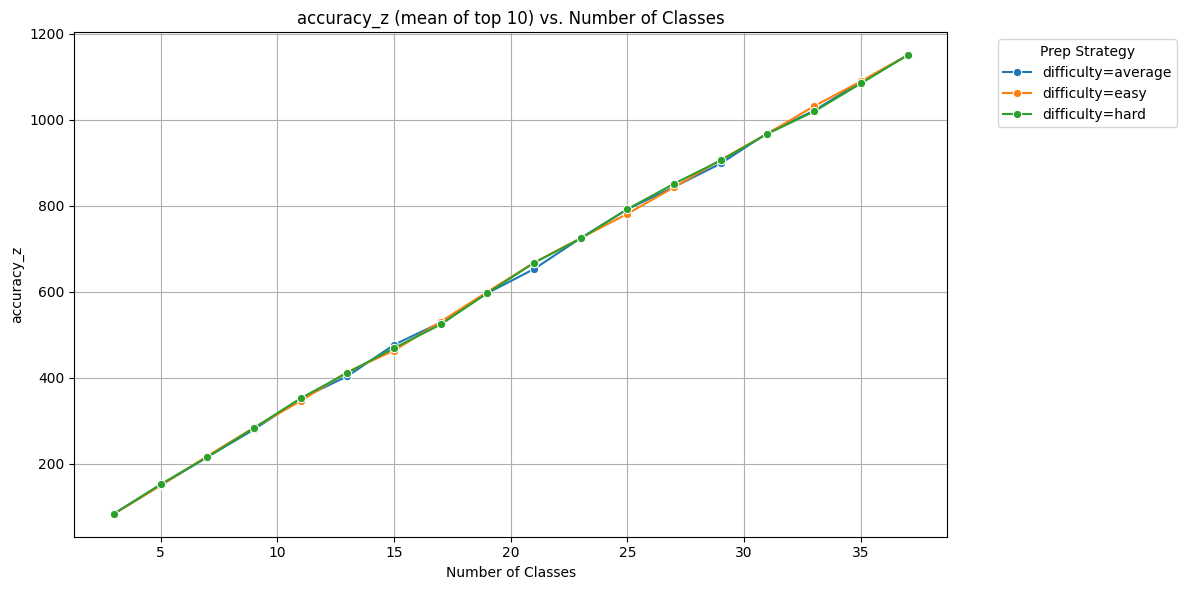

In [24]:
evolution(scores_df, prep_cols=['difficulty'])

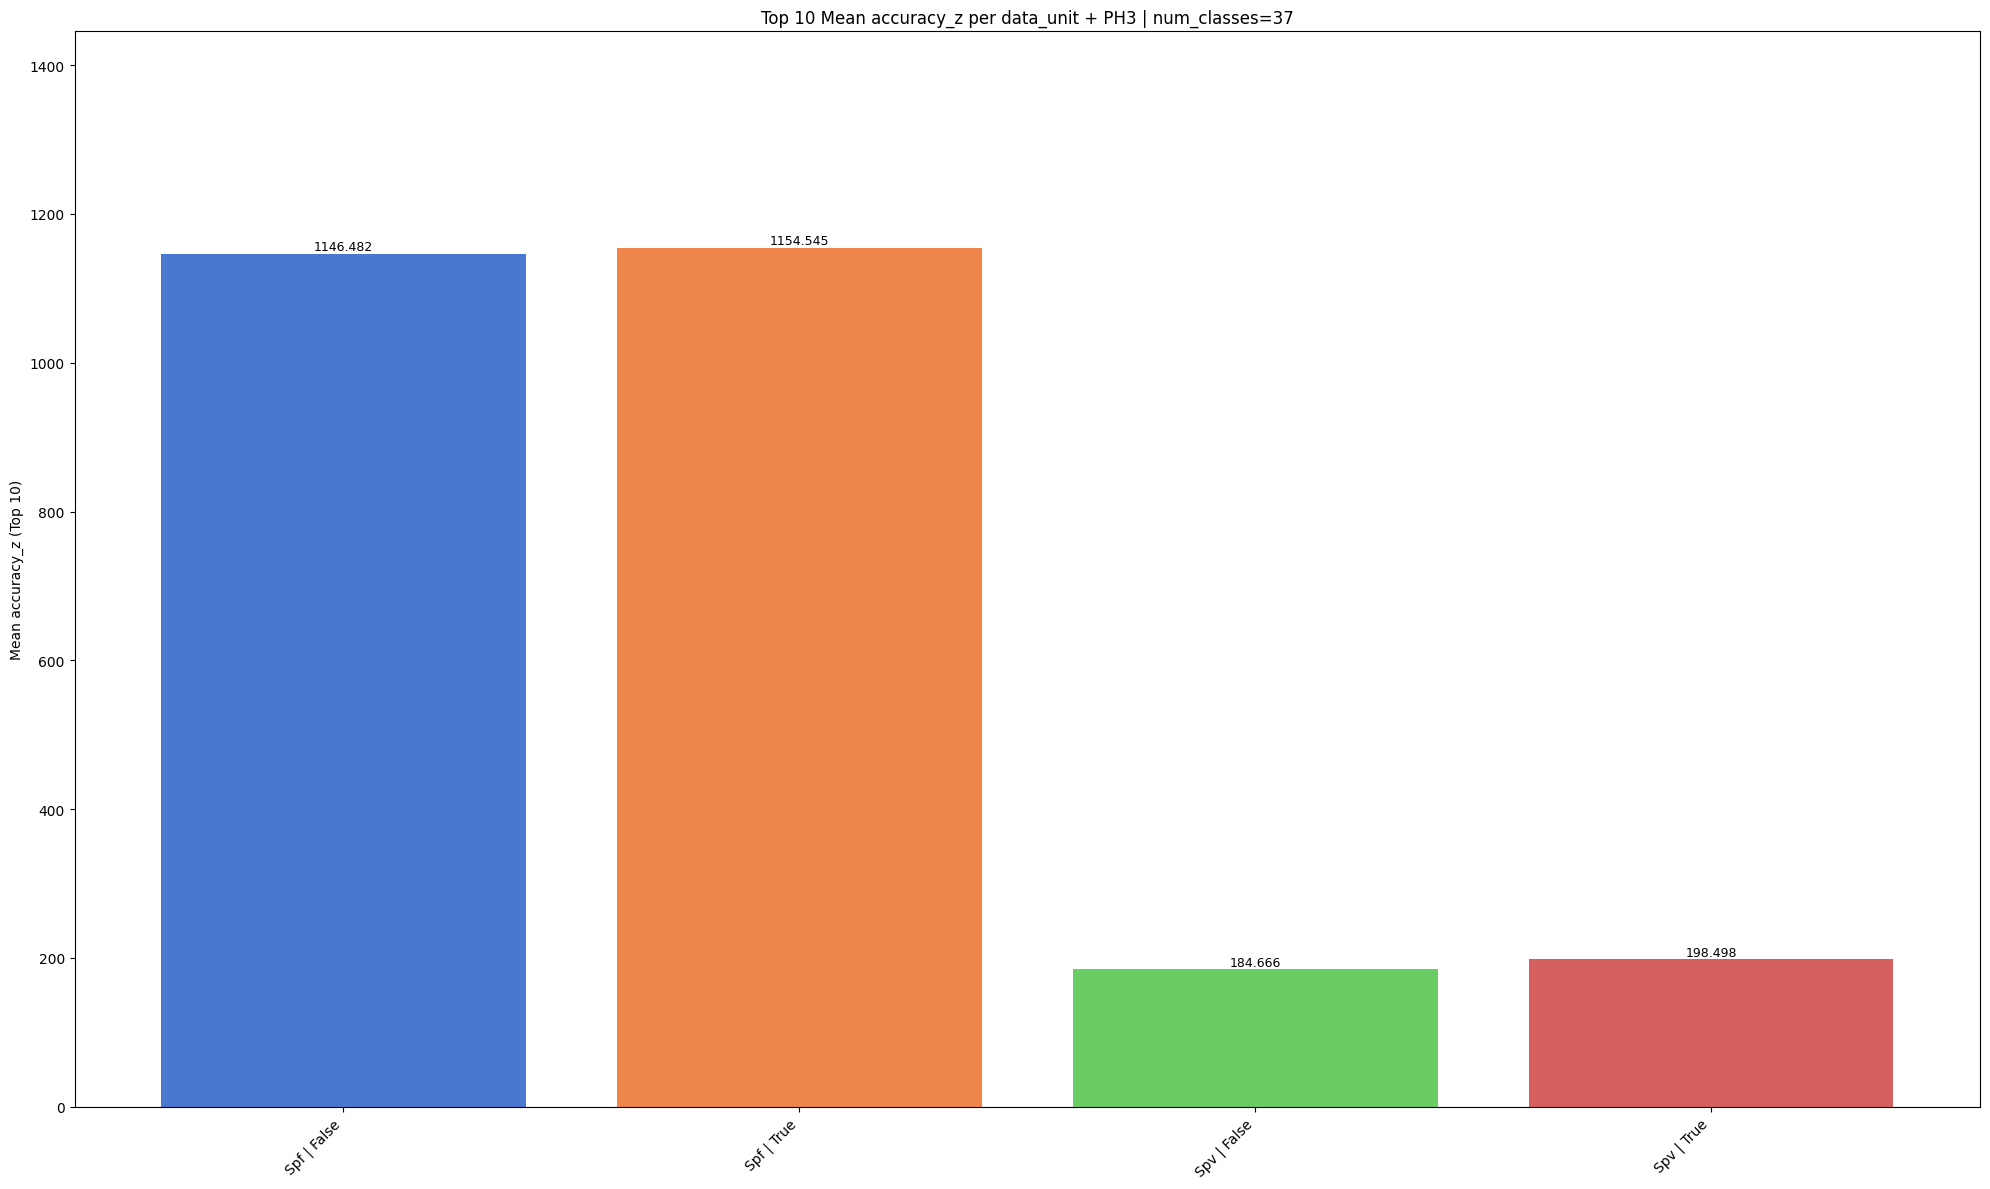

In [25]:
visualize(scores_df, group_cols=['data_unit', 'PH3'], filter_cols=['num_classes'], filter_values=[biggest_num_classes_tested], top=top_barrier)